In [41]:
import os
import ast
import glob
import json
import ineqpy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path

In [43]:
path_data = Path("../data")
path_meta = Path("../meta")
path_paper = path_meta / 'paper1'

font_size = 15

platform_abbreviation_mapping = {
    'gh': 'GitHub',
    'hf': 'Hugging Face Spaces',
    'pwc': 'Papers With Code',
    'ip': 'independent platform',
}

platform_abbreviation_mapping_inverse = {v: k for k, v in platform_abbreviation_mapping.items()}

leaderboard_organization_tactics_mapping = {
    'Evaluation Configuration': ['Dataset Slice', 'Evaluator', 'Metric'],
    'Leaderboard Aggregation': ['Aggregated Result'],
    'Leaderboard Release': ['Leaderboard Launch Date', 'Leaderboard Version'],
    'Model Capability': ['Benchmark Dataset', 'Service Load', 'Supported Functionality', 'Supported Language', 'Supported Modality', 'Task'],
    'Model Information': ['Model Accessibility', 'Model Size', 'Model Type'],
    'Prompt Engineering': ['#Prompt Example', 'Output Length', 'Prompt Design', 'Prompt Length', 'Relation Extractor', 'Tokenizer']
}

pwc_organization_strategies = {'Task'}

submission_avenue_synonyms = {
    'Competition': ['Hackathon']
}

macro_presentation_format_mapping = {
    'Table': ['Sortable Table', 'Regular Table', 'Table Screenshot'],
    'Figure': ['Bar Chart', 'Box Plot', 'Heatmap', 'Line Chart', 'Pie Chart', 'Radar Chart', 'Sortable Bar Chart', 'Scatter Plot'],
}

organizer_synonyms = {
    'Alibaba Group': ['Alibaba Group DAMO Academy', 'Aliyun'],
    'Amazon': ['Amazon Alexa AI Lab', 'Amazon AWS AI Lab'],
    'Agency for Science Technology and Research': ['A*STAR I2R', 'CFAR A*STAR'],
    'Bauhaus University': ['Bauhaus University Weimar'],
    'ByteDance': ['ByteDance AI Lab'],
    'Fraunhofer Society': ['Fraunhofer Institute for Integrated Circuits'],
    'Frédéric Joliot Institute for Life Sciences': ['NeuroSpin'],
    'Google': ['Google Brain', 'Google DeepMind', 'Google Blueshift'],
    'Huawei': ["Huawei Noah's Ark Lab"],
    'Max Planck Society': ['Max Planck Institute for Informatics', 'Max Planck Institute for Intelligent Systems', 'Max Planck Institute for Mathematics in the Sciences'],
    'Meta': [
        'Meta FAIR',
        'Meta GenAI'
    ],
    'Microsoft': ['Microsoft Research Asia'],
    'National Public School': ['National Public School HSR Layout'],
    'Naver': ['Naver Labs Europe'],
    'Queen\'s University Kingston': ['Queen\'s University'],
    'Tencent': [
        'Tencent AI Lab',
        'Tencent ARC Lab',
        'Tencent Youtu Lab'
    ],
    'Toyota Technological Institute': ['Toyota Technological Institute Chicago'],
    'University of California': [
        'University of California Berkeley',
        'University of California Los Angeles',
        'University of California Santa Barbara',
        'University of California San Diego',
        'University of California Irvine',
    ],
    'University of Michigan': ['University of Michigan Ann Arbor'],
    'University of North Carolina': ['University of North Carolina Chapel Hill'],
    'University of Illinois': ['University of Illinois Chicago', 'University of Illinois Urbana Champaign'],
    'University of Massachusetts': ['University of Massachusetts Amherst'],
    'University of Maryland': ['University of Maryland College Park'],
    'University of Tennessee': ['University of Tennessee Knoxville'],
    'University of Texas': ['University of Texas Austin'],
    'University of Wisconsin': ['University of Wisconsin Madison'],
}

metrics_synonyms = {
    'accuracy': [
        'acc',
        'accuarcy',
        'qa accuracy'
    ],
    'average': [
        'avg',
        '平均'
    ],
    'average accuracy': [
        'avg. accuracy'
    ],
    'average score': ['平均分'],
    'bleu': ['bleu score'],
    'bleu-1': [
        'narrativeqa bleu-1',
        'socialiqa bleu-1',
        'mcscript bleu-1',
        'cosmosqa bleu-1'
    ],
    'bleu-4': ['bleu4'],
    'bertscore': ['bert score'],
    'code': ['代码'],
    'elo rating': [
        'chatbot arena elo',
        'elo'
    ],
    'exact match': ['em', 'exact match accuracy'],
    'lerc': [
        'cosmosqa lerc',
        'mcscript lerc',
        'socialiqa lerc',
        'narrativeqa lerc'
    ],
    'link': ['url'],
    'mean rank': [
        'text-to-video mean rank',
        'video-to-text mean rank'
    ],
    'median rank': [
        'text-to-video median rank',
        'video-to-text median rank',
        'text-to-videomedian rank',
        'text-to-video medianr'
    ],
    'meteor': [
        'cosmosqa meteor',
        'narrativeqa meteor',
        'socialiqa meteor',
        'mcscript meteor'
    ],
    'neg mean rank': [
        'i->t neg mean rank',
        't->i neg mean rank'
    ],
    'organization': [
        '发布机构',
        '机构',
        'orgaisation',
    ],
    'others': ['其他'],
    'overall': ['xiezhi overall'],
    'overall score': [
        '总分',
        '总体分数'
    ],
    'pass@1': [
        'interview pass@1',
        'competition pass@1',
        'introductory pass@1'
    ],
    'pass@5': [
        'interview pass@5',
        'introductory pass@5',
        'competition pass@5'
    ],
    'pass@1000': [
        'interview pass@1000',
        'competition pass@1000',
        'introductory pass@1000'
    ],
    'pass@any': [
        'introductory pass@any',
        'competition pass@any',
        'interview pass@any'
    ],
    '#parameters':  [
        '#p',
        '#params',
        '# params',
        '#size',
        '参数量',
        'model size',
        'model size/b',
        'number of params',
        'param',
        'parameters',
        'params',
        'size'
    ],
    'perplexity': ['ppl'],
    'precision@1': ['i->t p@1'],
    'precision@20': ['p@20'],
    'recall@1': [
        'r@1',
        'text-to-videor@1',
        'video-to-text r@1',
        'text-to-video r@1',
        'text-to-image r@1',
        'image-to-text r@1'
    ],
    'recall@5': [
        'text-to-image r@5',
        'video-to-text r@5',
        'image-to-text r@5',
        'text-to-video r@5',
        'r@5',
    ],
    'recall@10': [
        'recall@10 on 1 rounds',
        'recall@10 on 2 rounds',
        'recall@10 on 3 rounds',
        'r@10',
        'video-to-text r@10',
        'text-to-image r@10',
        'text-to-video r@10',
        'image-to-text r@10'
    ],
    'recall@50': [
        'text-to-video r@50',
        'video-to-text r@50',
    ],
    'score': ['分数'],
    'submission date': ['提交时间'],
    'top-1 accuracy': ['top 1 accuracy'],
    'top-5 accuracy': ['top 5 accuracy'],
    'type': ['model type'],
    'win rate': ['胜率'],
    'word error rate': ['wer']
}

model_naming_convention = {
    'Model Publisher (first line)': [
        'Provider Leaderboard'
    ],
    'Repository Username': [
        'EQ-Bench (v2)',
        'HHEM Leaderboard',
        'Big Code Models Leaderboard',
        'Colossal-AI',
        'DecodingTrust',
        'LLMPerf Leaderboard',
        'LLM-Perf Leaderboard',
        'Open LLM Leaderboard',
        'Open Ko-LLM Leaderboard',
        'ScandEval'
    ],
}

presentation_format_pwc = ['Sortable Table', 'Scatter Plot']
dashed_model_leaderboards = ['MMCU', 'SuperCLUE-Math6']

metrics_synonyms_inverse = {}
for key, values in metrics_synonyms.items():
    for value in values:
        metrics_synonyms_inverse[value] = key

submission_avenue_synonyms_inverse = {}
for key, values in submission_avenue_synonyms.items():
    for value in values:
        submission_avenue_synonyms_inverse[value] = key

macro_presentation_format_mapping_inverse = {v: k for k, values in macro_presentation_format_mapping.items() for v in values}

organizer_synonyms_inverse = {}
for key, values in organizer_synonyms.items():
    for value in values:
        organizer_synonyms_inverse[value] = key

leaderboard_organization_tactics_mapping_inverse = {}
for key, values in leaderboard_organization_tactics_mapping.items():
    for value in values:
        leaderboard_organization_tactics_mapping_inverse[value] = key

model_naming_convention_count = {
    k: len(v) for k, v in model_naming_convention.items()}

def convert_df_to_dict(df):
    """
    Convert a DataFrame of leaderboards and metrics to a dictionary.

    :param df: DataFrame with leaderboards and metrics
    :return: Dictionary with leaderboards as keys and list of metrics as values
    """
    leaderboard_data = {}

    # Ensure the DataFrame's first column is considered as the keys
    # and iterate through each row to construct the dictionary
    for _, row in df.iterrows():
        key = row[0]  # The first column serves as the key
        # List comprehension to get non-empty values from the rest of the row
        values = [value for value in row[1:] if pd.notna(value)]
        leaderboard_data[key] = values

    return leaderboard_data


def string_to_list(text, platform=False):
    if pd.isna(text):
        return []
    elif platform:
        return [platform_abbreviation_mapping[platform] for platform in text.split(',')]
    else:
        return text.split(',')


def string_to_dict(s, platform=False):
    # Check if the input is np.nan
    if pd.isna(s):
        return {}
    # Split the string into key-value pairs
    pairs = s.split(',')
    result_dict = {}
    for pair in pairs:
        # Split each pair by ':' to separate keys and values
        key, value = pair.split(':')
        # Split the value by '+' to get the list of items
        value_list = value.split('+')
        # Assign the list to the key in the dictionary
        if platform:
            result_dict[platform_abbreviation_mapping[key]] = value_list
        else:
            result_dict[key] = value_list
    return result_dict


# Function to format each value based on its own decimal places
def format_individual_value(x):
    if isinstance(x, float):
        # Use string formatting to maintain original decimal places
        return "{:f}".format(x).rstrip('0').rstrip('.')
    return x


def print_empty_folders(root_dir):
    for dirpath, _, filenames in os.walk(root_dir):
        # Check if both lists of subdirectories and filenames are empty
        if not filenames:
            print(f"Empty folder: {dirpath}")


def process_model(model_str):
    if '](' in model_str:
        model_str = model_str.split('](')[0][1:]
        
    # Substrings to be removed
    substrings_to_remove = ['🥇', '🥈', '🥉', '🗒️', '📄', '🌍', '✨', '💙', '💚', '†', '*']
    
    # Remove each unwanted substring
    for substring in substrings_to_remove:
        model_str = model_str.replace(substring, '')
        
    return model_str.strip()
    

def list_directories(folder_path):
    # List all subdirectories within the folder
    directories = [os.path.join(folder_path, d) for d in os.listdir(
        folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return directories


def organizer_synonyms_mapping(organizers):
    organizers_processed = set()
    for organizer in organizers:
        if organizer in organizer_synonyms_inverse:
            organizers_processed.add(organizer_synonyms_inverse[organizer])
        # elif 'Independent Contributor' == organizer:
        #     organizers_processed.add(leaderboard)
        else:
            organizers_processed.add(organizer)
    return organizers_processed

def submission_avenue_synonyms_mapping(submission_avenue):
    submission_avenue_processed = set()
    for avenue in submission_avenue:
        if avenue in submission_avenue_synonyms_inverse:
            submission_avenue_processed.add(submission_avenue_synonyms_inverse[avenue])
        else:
            submission_avenue_processed.add(avenue)
    return submission_avenue_processed

In [21]:
xlsx = pd.ExcelFile(path_paper / 'Foundation Model Leaderboards.xlsx')
df = xlsx.parse('Leaderboard')

for index, row in df.iterrows():
    os.makedirs(path_data / row['Leaderboard name'], exist_ok=True) 

print_empty_folders(str(path_data))

In [50]:
directory = path_data / "Big Code Models Leaderboard"
channel = ''
drop_columns = []

for file in glob.glob(str(directory / "*.csv")):
    df = pd.read_csv(file)
    df.drop(columns=drop_columns, inplace=True)
    filename = file.split('\\')[-1]
    filename = filename.replace(".csv", ".json")
    if channel:
        filename = f'{channel}-{filename}'
    df.to_json(directory / filename, orient="records", indent=4)
    os.remove(file)


In [79]:
# Aligning Diverse Leaderboards for Standardized Analysis 
for directory in os.listdir(path_data):
    dash = directory in dashed_model_leaderboards
    subdirectory_path = os.path.join(path_data, directory)
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        try:
            df = pd.read_json(file)
            df['Model'] = df['Model'].str.replace('_', '-') if dash else df['Model'].apply(process_model)
            df.to_json(file, orient='records', indent=4)
        except:
            print(file)


In [7]:
total_records = 0
total_leaderboards = 0

for folder in list_directories(path_data):
    prefixes = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                df = pd.read_json(file_path)
                total_records += len(df)
                total_leaderboards += 1
                for prefix in platform_abbreviation_mapping.keys():
                    if file.startswith(prefix):
                        prefixes.append(prefix)
                        break

print(f"Total number of evaluation records: {total_records}")
print(f"Total number of leaderboards: {total_leaderboards}")

# xlsx = pd.ExcelFile(path_paper / 'Foundation Model Leaderboards.xlsx')
# df_benchmark = xlsx.parse('Benchmark')
# benchmark_mapping = convert_df_to_dict(df_benchmark)
# leaderboard_benchmarks = set()
# for key in benchmark_mapping.keys():
#     benchmarks = [benchmark if benchmark == 'ARC [Abstraction and Reasoning Corpus]' else benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]]
#     leaderboard_benchmarks = leaderboard_benchmarks.union(set(benchmarks))
# print('Total number of benchmarks:', len(leaderboard_benchmarks))


Total number of evaluation records: 75209
Total number of leaderboards: 2710


In [6]:
# with pd.ExcelFile(path_paper / 'Foundation Model Leaderboards.xlsx') as excel_file:
#     df_leaderboard = pd.read_excel(excel_file, sheet_name='Leaderboard')
#     df_leaderboard['Platforms'] = df_leaderboard['Platforms'].apply(lambda x: string_to_list(x, platform=True))
#     df_leaderboard['Presentation formats (non-pwc)'] = df_leaderboard['Presentation formats (non-pwc)'].apply(lambda x: string_to_dict(x, platform=True))
#     for index, row in df_leaderboard.iterrows():
#         platforms = row['Platforms']
#         if 'Papers With Code' in platforms:
#             continue
#         platforms_dict = row['Presentation formats (non-pwc)'].keys()
#         if set(platforms).difference(platforms_dict):
#             print(row['Leaderboard name'], platforms, platforms_dict)

In [49]:
with pd.ExcelFile(path_paper / 'Foundation Model Leaderboards.xlsx') as excel_file:
    df_leaderboard = pd.read_excel(excel_file, sheet_name='Leaderboard')

    df_leaderboard['Downloadable format'] = df_leaderboard['Downloadable format'].apply(string_to_list)
    df_leaderboard['Evaluation workflows (non-pwc)'] = df_leaderboard['Evaluation workflows (non-pwc)'].astype(str).apply(string_to_list)
    df_leaderboard['Organization strategies (non-pwc)'] = df_leaderboard['Organization strategies (non-pwc)'].apply(string_to_list)
    df_leaderboard['Platforms'] = df_leaderboard['Platforms'].apply(lambda x: string_to_list(x, platform=True))
    df_leaderboard['Presentation formats (non-pwc)'] = df_leaderboard['Presentation formats (non-pwc)'].apply(lambda x: string_to_dict(x, platform=True))
    df_leaderboard['Release organizations (non-pwc)'] = df_leaderboard['Release organizations (non-pwc)'].apply(string_to_list)
    df_leaderboard['Submission avenues (non-pwc)'] = df_leaderboard['Submission avenues (non-pwc)'].apply(string_to_list)
    df_leaderboard['Supported languages'] = df_leaderboard['Supported languages'].apply(string_to_list)
    df_leaderboard['Supported modalities'] = df_leaderboard['Supported modalities'].apply(string_to_list)

    df_leaderboard['Evaluated models'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Evaluation metrics (pwc)'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Organization strategies'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Release organizations'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Supported benchmarks'] = [set() for _ in range(len(df_leaderboard))]

    df_benchmark = pd.read_excel(excel_file, sheet_name='Benchmark')
    benchmark_mapping = convert_df_to_dict(df_benchmark)
    for key, values in benchmark_mapping.items():
        benchmark_mapping[key] = list(set([value.split(' (')[0] for value in values]))

    for index, row in df_leaderboard.iterrows():
        if row['Leaderboard name'] == 'MTEB':
            benchmarks = benchmark_mapping['MTEB'] + benchmark_mapping['CMTEB']
        elif row['Leaderboard name'] in benchmark_mapping:
            benchmarks = benchmark_mapping[row['Leaderboard name']]
        else:
            benchmarks = [row['Leaderboard name'].split(' (')[0]]
        df_leaderboard.at[index, 'Supported benchmarks'] = benchmarks
        df_leaderboard.at[index, '#Supported benchmark'] = len(benchmarks)

        presentation_formats = set()
        organizers = organizer_synonyms_mapping(row['Release organizations (non-pwc)'])
        organization_strategies = row['Organization strategies (non-pwc)']
        presentation_formats_mapping = row['Presentation formats (non-pwc)']
        submission_avenues = submission_avenue_synonyms_mapping(row['Submission avenues (non-pwc)'])
        for key, values in presentation_formats_mapping.items():
            presentation_formats = presentation_formats.union(set(values))
        if row['Platforms'] == ['Papers With Code']:
            organizers.add('Papers With Code')
            organization_strategies = pwc_organization_strategies.union(organization_strategies)
            presentation_formats = presentation_formats.union(presentation_format_pwc)
            presentation_formats_mapping['Papers With Code'] = presentation_format_pwc
        
        df_leaderboard.at[index, '#Presentation format'] = len(presentation_formats)
        df_leaderboard.at[index, '#Organization strategy'] = len(organization_strategies)
        df_leaderboard.at[index, '#Release organization'] = len(organizers)
        df_leaderboard.at[index, 'Organization strategies'] = organization_strategies
        df_leaderboard.at[index, 'Release organizations'] = organizers
        df_leaderboard.at[index, 'Submission avenues (non-pwc)'] = submission_avenues
    
        df_leaderboard.at[index, '#Host platform'] = len(row['Platforms'])
        df_leaderboard.at[index, '#Supported language'] = len(row['Supported languages'])
        df_leaderboard.at[index, '#Supported modality'] = len(row['Supported modalities'])

        records = 0
        leaderboards = 0
        model_names = set()
        template_metrics = set()
    
        for file in os.listdir(path_data / row['Leaderboard name']):
            host_platform = platform_abbreviation_mapping[file.split('.')[0].split('-')[0]]
            if host_platform not in row['Platforms']:
                continue
        
            file_path = path_data / row['Leaderboard name'] / file
            df = pd.read_json(file_path)
        
            leaderboards += 1
            records += len(df)
        
            if row['Leaderboard name'] in model_naming_convention['Repository Username']:
                df['Model'] = df['Model'].apply(lambda x: x.split('/')[-1])
            try:
                df['Model'] = df['Model'].apply(lambda x: x.split('\n')[0].split('(')[0].strip())
            except:
                print(row['Leaderboard name'])
            model_names = model_names.union(set(df['Model']))
        
            file_name = file.split('/')[-1]
            if file_name.startswith('pwc'):
                keys = set()
                for item in df['metrics']:
                    for key in item.keys():
                        key_processed = key.split('(')[0].lower().strip()
                        if key_processed in metrics_synonyms_inverse:
                            keys.add(metrics_synonyms_inverse[key_processed])
                        else:
                            keys.add(key_processed)
                template_metrics = template_metrics.union(keys)
    
        df_leaderboard.at[index, '#Evaluation record'] = records
        df_leaderboard.at[index, '#Evaluated model'] = len(model_names)
        df_leaderboard.at[index, 'Evaluated models'] = list(model_names)
        if leaderboards:
            df_leaderboard.at[index, '#Leaderboard'] = leaderboards
        if template_metrics:
            df_leaderboard.at[index, '#Evaluation metric (pwc)'] = len(template_metrics)
            df_leaderboard.at[index, 'Evaluation metrics (pwc)'] = list(template_metrics)
        
    df_leaderboard.to_csv(path_paper / 'leaderboard_processed.csv', index=False)


C:\Users\zhimi\AppData\Local\Temp\ipykernel_20904\169491407.py:278: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



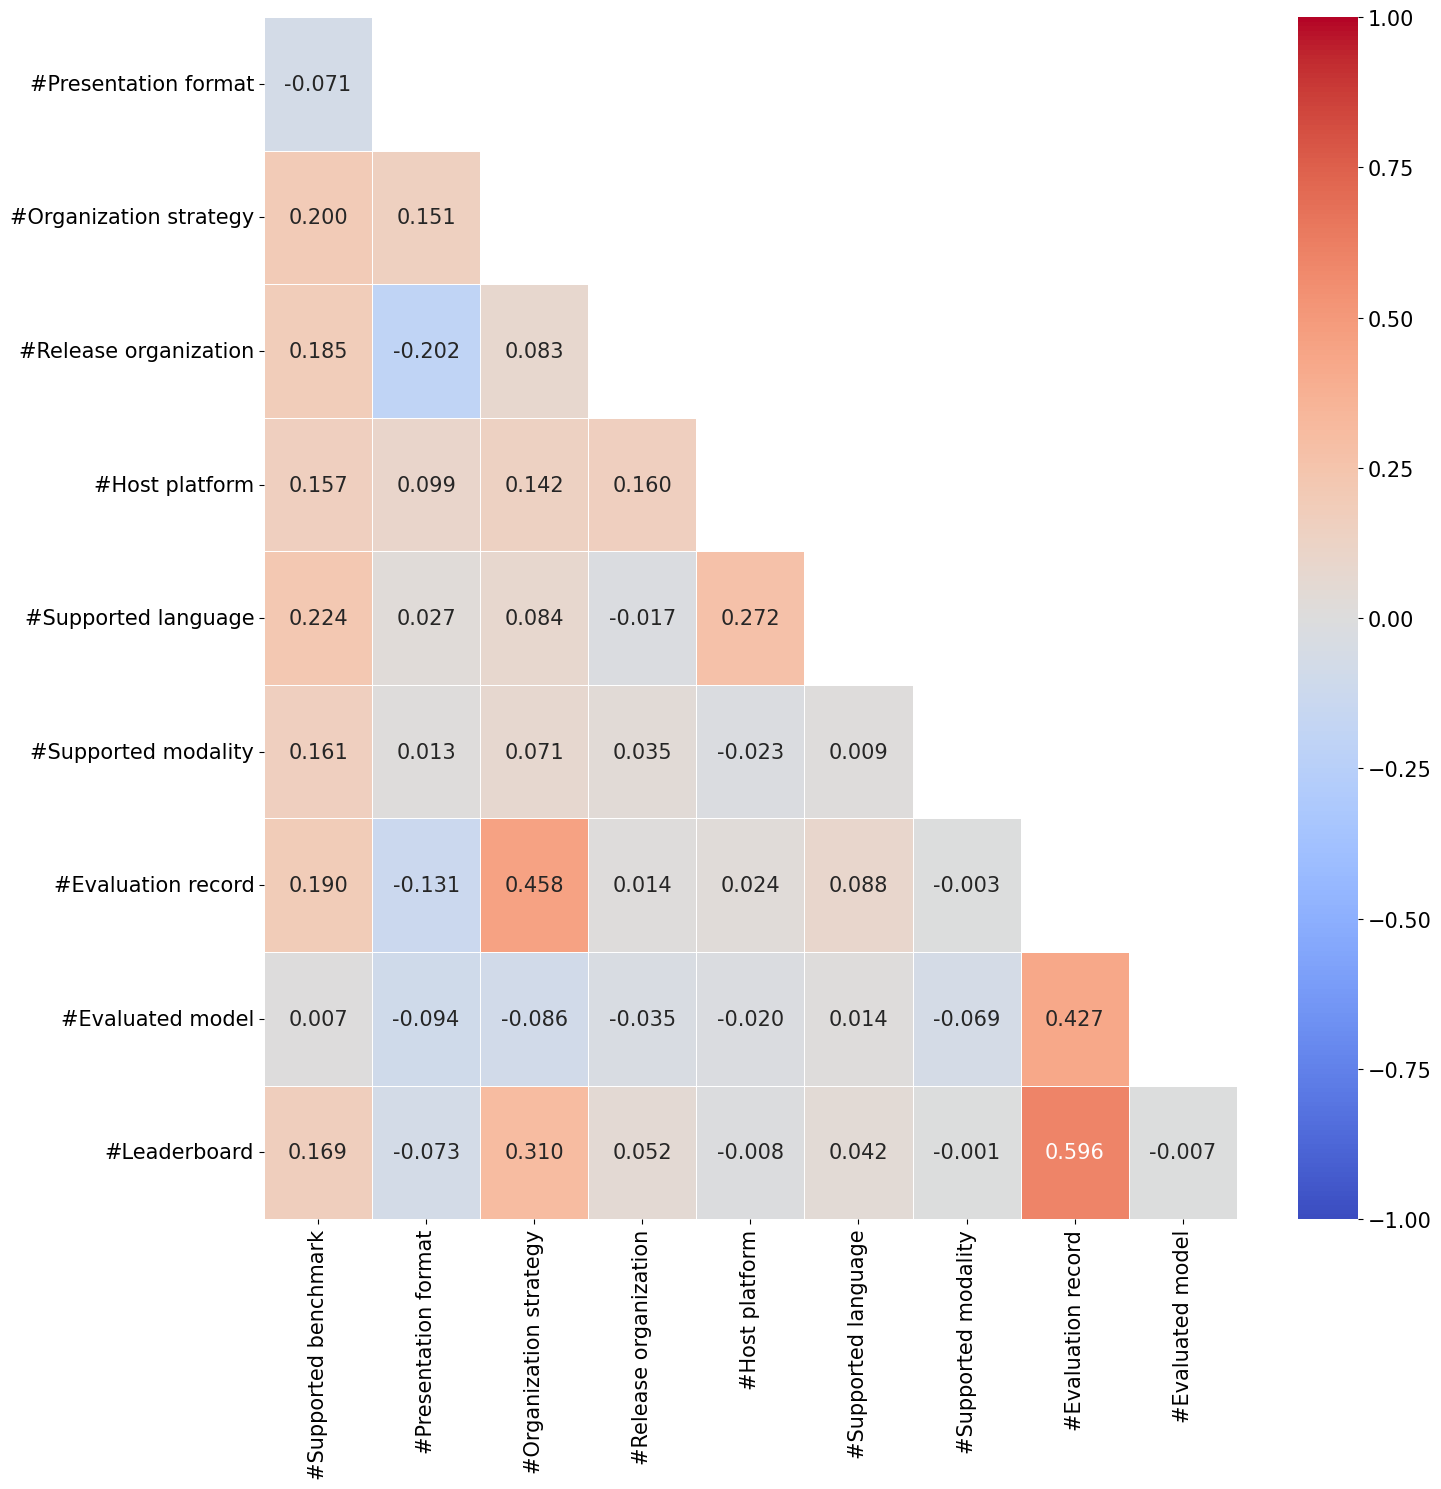

In [8]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['#Evaluation metric (pwc)'])
corr_matrix = numeric_df.corr()

# Drop the first row
corr_matrix_dropped_row = corr_matrix.drop(corr_matrix.index[0])

# Drop the last column
corr_matrix_dropped = corr_matrix_dropped_row.drop(corr_matrix_dropped_row.columns[-1], axis=1)

# Generate a mask for the upper triangle, including the diagonal
mask = np.triu(np.ones_like(corr_matrix_dropped, dtype=bool), 1)

# Generate a heatmap for the correlation matrix with the mask
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr_matrix_dropped, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, mask=mask, vmin=-1, vmax=1, annot_kws={"size": font_size})
# Enlarge axis font size
ax.tick_params(axis='both', which='major', labelsize=font_size)
# Adjust color bar (color scale) font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)  # Adjusts the tick labels' font size

plt.tight_layout()  # Adjust the layout to make sure everything fits
plt.savefig(path_paper / 'leaderboard-attribute-heatmap.pdf', format='pdf')
plt.show()


In [9]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['Organization strategies'].map(len) > 0]
print(f"{len(df[df['#Empty leaderboards (non-pwc)'].notna()])} multi-scenario leaderboards (excluding Papers With Code) have missing scenarios, accounting for {round(len(df[df['#Empty leaderboards (non-pwc)'].notna()])/len(df)*100,2)}% of the total.")
df['#Empty leaderboards (non-pwc)'].value_counts().reset_index(name='Frequency')

4 multi-scenario leaderboards (excluding Papers With Code) have missing scenarios, accounting for 0.99% of the total.


,#Empty leaderboards (non-pwc),Frequency
0,2,2
1,Unknown,2


Regular Table is the most prevalent presentation format in leaderboards hosted on GitHub, accounting for 69.72% (76 out of 109) leaderboards.
Sortable Table is the most prevalent presentation format in leaderboards hosted on Hugging Face Spaces, accounting for 97.37% (74 out of 76) leaderboards.
Sortable Table is the most prevalent presentation format in leaderboards hosted on Papers With Code, accounting for 97.87% (184 out of 188) leaderboards.
Sortable Table is the most prevalent presentation format in leaderboards hosted on independent platform, accounting for 69.62% (55 out of 79) leaderboards.


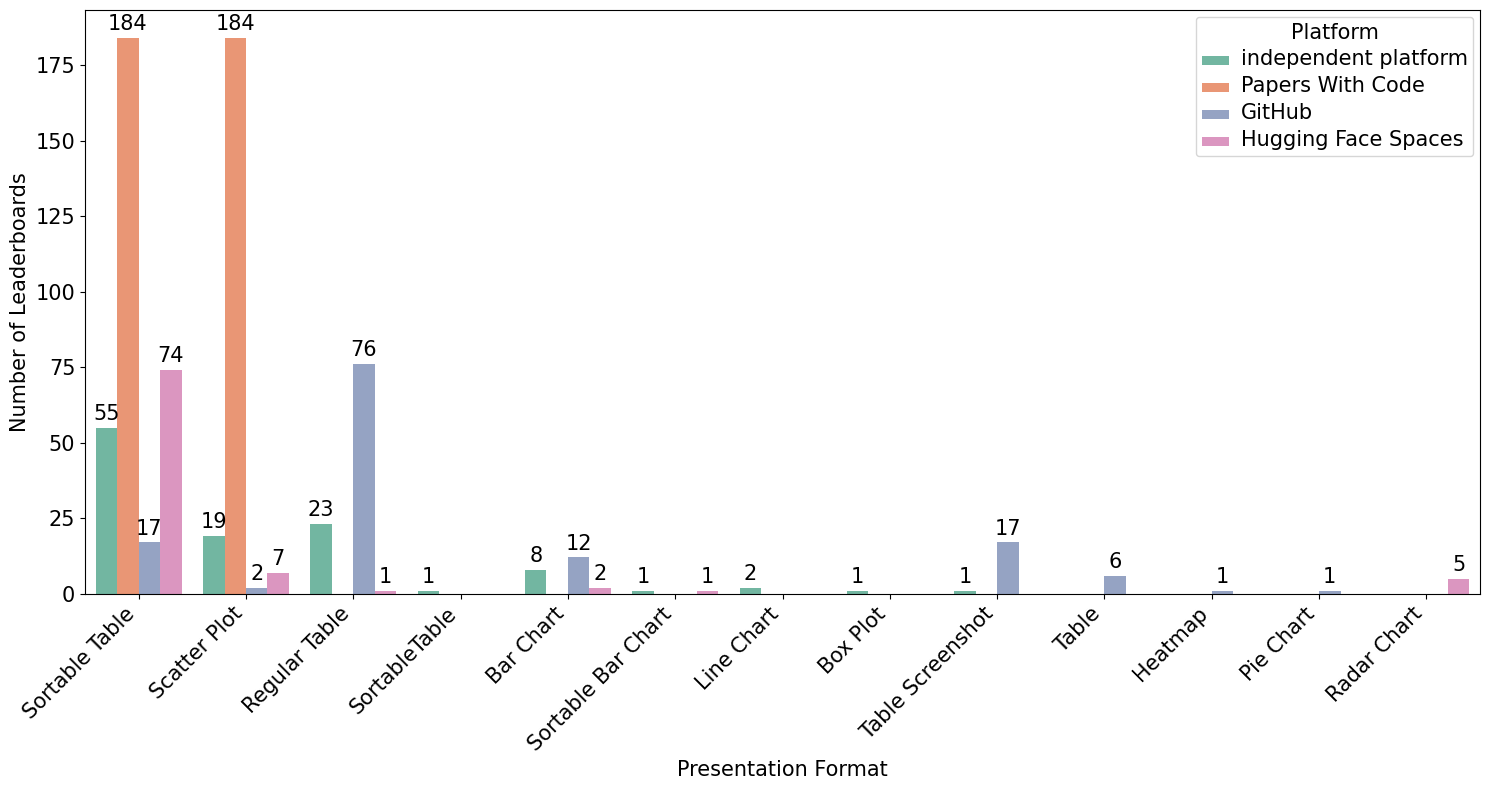

In [10]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df['Presentation formats (non-pwc)'] = df['Presentation formats (non-pwc)'].apply(ast.literal_eval)
df['Platforms'] = df['Platforms'].apply(ast.literal_eval)

format_counts = defaultdict(lambda: defaultdict(int))
for index, row in df.iterrows():
    # Loop through each platform and its formats in the dictionary
    for platform, formats in row['Presentation formats (non-pwc)'].items():
        for format_type in formats:
            # Increment the count for the format type under its respective platform
            format_counts[platform][format_type] += 1
            
flattened_data = []
for platform, formats in format_counts.items():
    for format_type, count in formats.items():
        flattened_data.append({'Platform': platform, 'Presentation Format': format_type, 'Frequency': count})
        
df_presentation = pd.DataFrame(flattened_data)
df = df.explode('Platforms')
for name, group in df_presentation.groupby('Platform'):
    group = group.sort_values(by='Frequency', ascending=False)
    print(f"{group['Presentation Format'].iloc[0]} is the most prevalent presentation format in leaderboards hosted on {name}, accounting for {round(group['Frequency'].iloc[0]/len(df[df['Platforms'] == name])*100,2)}% ({group['Frequency'].iloc[0]} out of {len(df[df['Platforms'] == name])}) leaderboards.")

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed
ax = sns.barplot(
    x='Presentation Format', 
    y='Frequency', 
    hue='Platform',  # This separates the bars within each group by platform
    data=df_presentation, 
    palette='Set2',  # Choose a palette that makes the bars distinct
    dodge=True  # Adjust this to control the gap between bars of different platforms within the same group
)

# Setting the title and labels with enlarged fonts
ax.set_xlabel('Presentation Format', fontsize=font_size)  # Enlarge x-axis label
ax.set_ylabel('Number of Leaderboards', fontsize=font_size)  # Enlarge y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Enlarge axis ticks font size
ax.tick_params(axis='both', which='major', labelsize=font_size)

# Adding annotations on top of each bar
for p in ax.patches:
    if p.get_height():
        ax.annotate(format(p.get_height(), '.0f'),  # Format the number presentationed
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha = 'center', va = 'center', 
                xytext = (0, 10),  # Distance from the top of the bar
                textcoords = 'offset points', fontsize=font_size)

# Adjust the legend
leg = ax.legend(title='Platform')
leg.set_title('Platform', prop={'size':font_size})  # Set the title font size
for text in leg.get_texts():  # Set the font size for each legend text
    text.set_fontsize(font_size)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
# Save the plot to a PDF file
plt.savefig(path_paper / 'presentation-format-distribution.pdf', bbox_inches='tight')
plt.show()

df_split = df_presentation.groupby('Presentation Format').sum().reset_index()
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Presentation Formats',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
if os.path.exists(path_paper / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)


In [11]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')

statistics = {
    'Distribution': 'Presentation Formats across Leaderboard Systems',
    'Mean': np.mean(df['#Presentation format']),
    'Median': np.median(df['#Presentation format']),
    'IQR': df['#Presentation format'].quantile(0.75) - df['#Presentation format'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Presentation format', ascending=False).head(15)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of presentation formats up to {int(df_top['#Presentation format'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Presentation format'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Presentation format'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Presentation Format',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

Models Leaderboard supports the highest number of presentation formats up to 5.


In [12]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df['Downloadable format'] = df['Downloadable format'].apply(ast.literal_eval)
print(f"{round(len(df[df['Downloadable format'].map(len) > 0])/len(df)*100,2)}% ({len(df[df['Downloadable format'].map(len) > 0])} out of {len(df)}) leaderboard systems provide downloadable format of the leaderboards.")

df = df[df['Downloadable format'].map(len) > 0]
df_split = df.explode('Downloadable format')['Downloadable format'].value_counts().reset_index(name='Frequency')
print(f"{df_split['Downloadable format'].iloc[0]} is the most popular storage format of leaderboards, accounting for {round(df_split['Frequency'].iloc[0]/len(df)*100,2)}% ({df_split['Frequency'].iloc[0]} out of {len(df)}) downloadable leaderboard systems.")
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Downloadable Formats',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=df_split['Downloadable format'],
    y=df_split['Frequency'],
    text_auto=True,
    labels={'x': 'Downloadable format', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

12.07% (49 out of 406) leaderboard systems provide downloadable format of the leaderboards.
CSV is the most popular storage format of leaderboards, accounting for 81.63% (40 out of 49) downloadable leaderboard systems.


In [13]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df['Platforms'] = df['Platforms'].apply(ast.literal_eval)
print(f"{round(len(df[df['Platforms'].map(len) > 1])/len(df)*100,2)}% ({len(df[df['Platforms'].map(len) > 1])} out of {len(df)}) leaderboards are hosted on multiple platforms.")

df_split = df.explode('Platforms')['Platforms'].value_counts().reset_index(name='Frequency')
print(f"{df_split['Platforms'].iloc[0]} is the most popular host platform, accounting for {round(df_split['Frequency'].iloc[0]/len(df)*100,2)}% ({df_split['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Platforms',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=df_split['Platforms'],
    y=df_split['Frequency'],
    text_auto=True,
    labels={'x': 'Platforms', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

10.59% (43 out of 406) leaderboards are hosted on multiple platforms.
Papers With Code is the most popular host platform, accounting for 46.31% (188 out of 406) leaderboards.


In [14]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')

statistics = {
    'Distribution': 'Platforms across Leaderboard Systems',
    'Mean': np.mean(df['#Host platform']),
    'Median': np.median(df['#Host platform']),
    'IQR': df['#Host platform'].quantile(0.75) - df['#Host platform'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Host platform', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} is hosted by the highest number of platforms up to {int(df_top['#Host platform'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Host platform'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Host platform'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Platforms',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

MTEB is hosted by the highest number of platforms up to 4.


In [15]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')

df['Release organizations'] = df['Release organizations'].apply(ast.literal_eval)
df_split = df.explode('Release organizations').groupby('Release organizations').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Release Organizations',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Release organizations'].iloc[0]} is the most productive publisher among the {len(df)} publishers, accounting for {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Release organizations'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboard Systems across Release Organizations (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publisher Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


Papers With Code is the most productive publisher among the 406 publishers, accounting for 45.32% (184 out of 406) leaderboards.


In [16]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['Platforms'] != "['Papers With Code']"]

statistics = {
    'Distribution': 'Release Organizations across Leaderboard Systems',
    'Mean': np.mean(df['#Release organization']),
    'Median': np.median(df['#Release organization']),
    'IQR': df['#Release organization'].quantile(0.75) - df['#Release organization'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Release organization', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} holds the highest number of release organizations up to {int(df_top['#Release organization'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Release organization'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Release organization'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Release Organization',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


TrustLLM holds the highest number of release organizations up to 36.


In [19]:
# df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
# df_pub = df[df['Publication venues'].notna()]
# print(f"{round(len(df_pub)/len(df)*100,2)}% ({len(df_pub)} out of {len(df)}) leaderboards are associated with specific publications, including articles, preprints, and reports.")

# df_pub['Publication venues'] = df_pub['Publication venues'].apply(ast.literal_eval)
# df_accepted = df_pub[df_pub['Publication venues'].apply(lambda x: 'Preprint' not in x)]
# print(f"{round(len(df_accepted)/len(df)*100,2)}%  ({len(df_accepted)} out of {len(df_pub)}) articles have been accepted in a specific workshop, conference, and journal.")

# df_split = df_accepted.explode('Publication venues').groupby('Publication venues').size().reset_index(name='Frequency')
# df_split['Weight'] = 1

# statistics = {
#     'Distribution': 'Leaderboard Systems across Publication Venues',
#     'Mean': np.mean(df_split['Frequency']),
#     'Median': np.median(df_split['Frequency']),
#     'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
#     'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
# }
# df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

# df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
# print(f"{df_top['Publication venues'].iloc[0]} emerges as the conference with the most number of accepted articles, accounting for {round(df_top['Frequency'].iloc[0]/len(df_accepted)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df_accepted)}) of the total.")

# fig = go.Figure(go.Bar(
#         x=df_top['Frequency'],  # Values for the bar lengths
#         y=df_top['Publication venues'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['Frequency'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         title=f'Number of Leaderboards with Accepted Articles across Publication Venues (Top 10)',
#         xaxis_title='Leaderboard Number',
#         yaxis_title='Publication Name',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# fig.show()


100.0% (354 out of 354) leaderboards are associated with specific publications, including articles, preprints, and reports.
68.64%  (243 out of 354) articles have been accepted in a specific workshop, conference, and journal.
EMNLP emerges as the conference with the most number of accepted articles, accounting for 12.76% (31 out of 243) of the total.


In [17]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df_split = df[df['#Organization strategy'] > 0]
print(f'{round(len(df_split)/len(df)*100,2)}% ({len(df_split)} out of {len(df)}) non-pwc leaderboards have adopted multiple organization strategies.')

statistics = {
    'Distribution': 'Organization Strategies across Leaderboard Systems',
    'Mean': np.mean(df_split['#Organization strategy']),
    'Median': np.median(df_split['#Organization strategy']),
    'IQR': df_split['#Organization strategy'].quantile(0.75) - df_split['#Organization strategy'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Organization strategy', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has adopted the highest number of organization strategies up to {int(df_top['#Organization strategy'].iloc[0])} among non-pwc leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['#Organization strategy'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Organization strategy'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Organization Strategy',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


70.44% (286 out of 406) non-pwc leaderboards have adopted multiple organization strategies.
HELM Classic has adopted the highest number of organization strategies up to 10 among non-pwc leaderboards.


In [18]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['#Organization strategy'] > 0]

df['Organization strategies'] = df['Organization strategies'].apply(ast.literal_eval)
df_split = df.explode('Organization strategies').groupby('Organization strategies').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Organization Strategies',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Organization strategies'].iloc[0]} is the most adopted organization strategy, involving {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) multi-split leaderboard systems.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Organization strategies'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Organization Strategy',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


Task is the most adopted organization strategy, involving 77.62% (222 out of 286) multi-split leaderboard systems.


In [19]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')

statistics = {
    'Distribution': 'Supported Languages across Leaderboard Systems',
    'Mean': np.mean(df['#Supported language']),
    'Median': np.median(df['#Supported language']),
    'IQR': df['#Supported language'].quantile(0.75) - df['#Supported language'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported language', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of languages up to {int(df_top['#Supported language'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported language'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported language'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Languages',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


MTEB supports the highest number of languages up to 112.


In [21]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df['Supported languages'] = df['Supported languages'].apply(ast.literal_eval)

df_split = df.explode('Supported languages').groupby('Supported languages').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Supported Languages',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported languages']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported languages'].iloc[0]} is the most supported language in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported languages'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported language',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

English is the most supported language in 87.19% (354 out of 406) leaderboards.


In [22]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')

statistics = {
    'Distribution': 'Supported Modalities across Leaderboard Systems',
    'Mean': np.mean(df['#Supported modality']),
    'Median': np.median(df['#Supported modality']),
    'IQR': df['#Supported modality'].quantile(0.75) - df['#Supported modality'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported modality', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of modality up to {int(df_top['#Supported modality'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported modality'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported modality'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Modality',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


FlagEval supports the highest number of modality up to 4.


In [23]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df['Supported modalities'] = df['Supported modalities'].apply(ast.literal_eval)

df_split = df.explode('Supported modalities').groupby('Supported modalities').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Supported Modalities',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported modalities']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported modalities'].iloc[0]} is the most supported modality by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported modalities'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported Modality',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

Text is the most supported modality by 100.0% (406 out of 406) leaderboards.


In [24]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')

statistics = {
    'Distribution': 'Supported Benchmarks across Leaderboard Systems',
    'Mean': np.mean(df['#Supported benchmark']),
    'Median': np.median(df['#Supported benchmark']),
    'IQR': df['#Supported benchmark'].quantile(0.75) - df['#Supported benchmark'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported benchmark', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of {int(df_top['#Supported benchmark'].iloc[0])} benchmarks.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported benchmark'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported benchmark'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Benchmarks',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


BIG-Bench supports the highest number of 209 benchmarks.


In [25]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df['Supported benchmarks'] = df['Supported benchmarks'].apply(ast.literal_eval)

df_split = df.explode('Supported benchmarks').groupby('Supported benchmarks').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Supported Benchmarks',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported benchmarks']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported benchmarks'].iloc[0]} is the most supported benchmark by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported benchmarks'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported Benchmark',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

MMLU is the most supported benchmark by 6.4% (26 out of 406) leaderboards.


In [26]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')

statistics = {
    'Distribution': 'Evaluated Models across Leaderboard Systems',
    'Mean': np.mean(df['#Evaluated model']),
    'Median': np.median(df['#Evaluated model']),
    'IQR': df['#Evaluated model'].quantile(0.75) - df['#Evaluated model'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluated model', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluated model'].iloc[0])} models evaluated.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluated model'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluated model'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluated Models',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


Open LLM Leaderboard (GPT) has the highest number of 4998 models evaluated.


In [27]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df['Evaluated models'] = df['Evaluated models'].apply(ast.literal_eval)

df_split = df.explode('Evaluated models').groupby('Evaluated models').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Evaluated Models',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Evaluated models']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Evaluated models'].iloc[0]} is the most widely evaluated model in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Evaluated models'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Evaluated Model',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

GPT-4 is the most widely evaluated model in 14.53% (59 out of 406) leaderboards.


In [28]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['Platforms'] == "['Papers With Code']"]

statistics = {
    'Distribution': 'Evaluation Metrics across Leaderboard Systems',
    'Mean': np.mean(df['#Evaluation metric (pwc)']),
    'Median': np.median(df['#Evaluation metric (pwc)']),
    'IQR': df['#Evaluation metric (pwc)'].quantile(0.75) - df['#Evaluation metric (pwc)'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation metric (pwc)', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation metric (pwc)'].iloc[0])} evaluation metrics.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation metric (pwc)'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation metric (pwc)'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Metrics',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


ChEBI-20 has the highest number of 20 evaluation metrics.


In [29]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['Platforms'] == "['Papers With Code']"]
df['Evaluation metrics (pwc)'] = df['Evaluation metrics (pwc)'].apply(ast.literal_eval)

df_split = df.explode('Evaluation metrics (pwc)').groupby('Evaluation metrics (pwc)').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Evaluation Metrics',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Evaluation metrics (pwc)']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Evaluation metrics (pwc)'].iloc[0]} is the most prevalent evaluation metrics in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Evaluation metrics (pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Evaluation Metric',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

accuracy is the most prevalent evaluation metrics in 40.76% (75 out of 184) leaderboards.


In [30]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['#Leaderboard'] > 0]

statistics = {
    'Distribution': 'Leaderboards across Multi-split Leaderboard Systems',
    'Mean': np.mean(df['#Leaderboard']),
    'Median': np.median(df['#Leaderboard']),
    'IQR': df['#Leaderboard'].quantile(0.75) - df['#Leaderboard'].quantile(0.25),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Leaderboard', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Leaderboard'].iloc[0])} leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Split Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


LMExamQA has the highest number of 887 leaderboards.


In [31]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df['Weight'] = 1

statistics = {
    'Distribution': 'Evaluation Records across Leaderboard Systems',
    'Mean': np.mean(df['#Evaluation record']),
    'Median': np.median(df['#Evaluation record']),
    'IQR': df['#Evaluation record'].quantile(0.75) - df['#Evaluation record'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df, income='#Evaluation record', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation record', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation record'].iloc[0])} evaluation records.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation record'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation record'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Records',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


HELM Classic has the highest number of 16005 evaluation records.


In [34]:
# df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
# df = df[df['Platforms'] != "['Papers With Code']"]
# df['Platforms'] = df['Platforms'].apply(ast.literal_eval)

# df['Platforms with model linkage (non-pwc)'] = df['Platforms with model linkage (non-pwc)'].apply(ast.literal_eval)
# df_provenance = df[df['Platforms with model linkage (non-pwc)'].map(len) > 0]
# print(f"{round(len(df_provenance)/len(df)*100,2)}% ({len(df_provenance)} out of {len(df)}) leaderboards hosted on other platforms provide accessible links to the provenance information of the evaluated models.")
# df_split = df_provenance.explode('Platforms with model linkage (non-pwc)')
# df_split = df_split['Platforms with model linkage (non-pwc)'].value_counts().reset_index(name='Frequency')

# total_data = 0
# total_provenance = 0
# for root, dirs, files in os.walk(path_data):
#     for file in files:
#         if file.startswith('pwc') and file.endswith(".json"):
#             with open(os.path.join(root, file), 'r') as file:
#                 json_data = json.load(file)
#                 total_data += len(json_data)
#                 json_external = [external for external in json_data if type(external['external_source_url']) == str]
#                 total_provenance += len(json_external)
#                 if not len(json_external):
#                     json_internal = [paper for paper in json_data if type(paper['paper']['id']) == int]
#                     total_provenance += len(json_internal)
# print(f'For Papers With Code leaderboards, the overall provenance rate across all leaderboards is {round(total_provenance/total_data*100, 2)}%, equivalent to {total_provenance} out of {total_data} evaluation records.')

# fig = px.bar(
#     x=df_split['Platforms with model linkage (non-pwc)'],
#     y=df_split['Frequency'],
#     text_auto=True,
#     labels={'x': 'Platforms', 'y': 'Count of leaderboards with model provenance linkage'},
#     title='Number of Leaderboards with Model Provenance Linkage across Platforms (non-pwc)'
# )
# fig.show()


50.0% (87 out of 174) leaderboards hosted on other platforms provide accessible links to the provenance information of the evaluated models.
For Papers With Code leaderboards, the overall provenance rate across all leaderboards is 98.08%, equivalent to 7619 out of 7768 evaluation records.


In [43]:
# df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
# df = df[df['Platforms'] != "['Papers With Code']"]
# df['Submission avenues (non-pwc)'] = df['Submission avenues (non-pwc)'].apply(ast.literal_eval)

# df_submission = df[df['Submission avenues (non-pwc)'].map(len) > 0]
# print(f"{round(len(df_submission)/len(df)*100,2)}% ({len(df_submission)} out of {len(df)}) leaderboards provide at least one submission guideline for new evaluation records.")

# df_avenue = df_submission.explode('Submission avenues (non-pwc)')
# df_split = df_avenue['Submission avenues (non-pwc)'].value_counts().reset_index(name='Frequency')
# df_split['Weight'] = 1
# print(f"{df_split['Submission avenues (non-pwc)'].iloc[0]} is the most prevalent submission avenue, accounting for {round(df_split['Frequency'].iloc[0]/len(df_submission)*100,2)}% ({df_split['Frequency'].iloc[0]} out of {len(df_submission)}) leaderboards.")

# statistics = {
#     'Distribution': 'Leaderboard Systems across Submission & Collection Avenues',
#     'Mean': np.mean(df_split['Frequency']),
#     'Median': np.median(df_split['Frequency']),
#     'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
#     'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
# }
# df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

# fig = px.bar(
#     x=df_split['Submission avenues (non-pwc)'], 
#     y=df_split['Frequency'],
#     text_auto=True,
#     labels={'x': 'Submission avenues (non-pwc)', 'y': 'Leaderboard Number'},
#     title='Number of Leaderboard Systems across Submission & Collection Avenues (non-pwc)'
# )
# fig.show()

58.05% (101 out of 174) leaderboards provide at least one submission guideline for new evaluation records.
Submission Portal is the most prevalent submission avenue, accounting for 46.53% (47 out of 101) leaderboards.


In [32]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['Platforms'] != "['Papers With Code']"]
print(f'There are {len(df)} non-pwc leaderboard systems.')

df['Evaluation workflows (non-pwc)'] = df['Evaluation workflows (non-pwc)'].apply(ast.literal_eval)
df_workflow = df.explode('Evaluation workflows (non-pwc)')
df_workflow = df_workflow.groupby('Evaluation workflows (non-pwc)').size().reset_index(name='Frequency')
df_workflow['Evaluation workflows (non-pwc)'] = df_workflow['Evaluation workflows (non-pwc)'].apply(lambda x: f'Pattern {x}' if x != 'Unknown' else x)
df_workflow.sort_values(by='Frequency', ascending=False, inplace=True)
df_workflow['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Evaluation Workflows',
    'Mean': np.mean(df_workflow['Frequency']),
    'Median': np.median(df_workflow['Frequency']),
    'IQR': df_workflow['Frequency'].quantile(0.75) - df_workflow['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_workflow, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=df_workflow['Evaluation workflows (non-pwc)'], 
    y=df_workflow['Frequency'],
    text_auto=True,
    labels={'x': 'Evaluation workflows (non-pwc)', 'y': 'Leaderboard Number'},
    title='Number of Leaderboard Systems across Evaluation Workflows (non-pwc)'
)
fig.show()

There are 222 non-pwc leaderboard systems.


In [34]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['Platforms'] == "['Papers With Code']"]

total = 0
evalai = 0
huggingface = 0
paperswithcode = 0

for root, dirs, files in os.walk(path_data):
    for file in files:
        if file.startswith('pwc') and file.endswith(".json"):
            with open(os.path.join(root, file), 'r') as file:
                total += 1
                for external in json.load(file):
                    if type(external['external_source_url']) != str:
                        paperswithcode += 1
                        break
                    elif 'eval.ai' in external['external_source_url']:
                        evalai += 1 
                        break
                    elif 'huggingface.co' in external['external_source_url']:  
                        huggingface += 1
                        break
                    
pwc_workflow_pattern_mapping = {
    'Evaluation Workflow 2': huggingface + evalai,
    'Evaluation Workflow 5': paperswithcode,
}
pwc_workflow_pattern_mapping, total

({'Evaluation Workflow 2': 213, 'Evaluation Workflow 5': 456}, 669)

There are 222 non-pwc leaderboard systems.
56.31% (125 out of 222) leaderboards provide at least one submission & collection guideline for new evaluation records.


Competition is the most prevalent avenue in evaluation workflow Pattern 1, accounting for 33.33% (2 out of 6) leaderboard systems.
Model Card is the most prevalent avenue in evaluation workflow Pattern 3, accounting for 100.0% (1 out of 1) leaderboard systems.
Model Card is the most prevalent avenue in evaluation workflow Pattern 4, accounting for 100.0% (1 out of 1) leaderboard systems.
Email is the most prevalent avenue in evaluation workflow Pattern 5, accounting for 38.89% (7 out of 18) leaderboard systems.
Submission Portal is the most prevalent avenue in evaluation workflow Pattern 6, accounting for 57.97% (40 out of 69) leaderboard systems.
Submission Portal is the most prevalent avenue in evaluation workflow Pattern 7, accounting for 43.18% (19 out of 44) leaderboard systems.


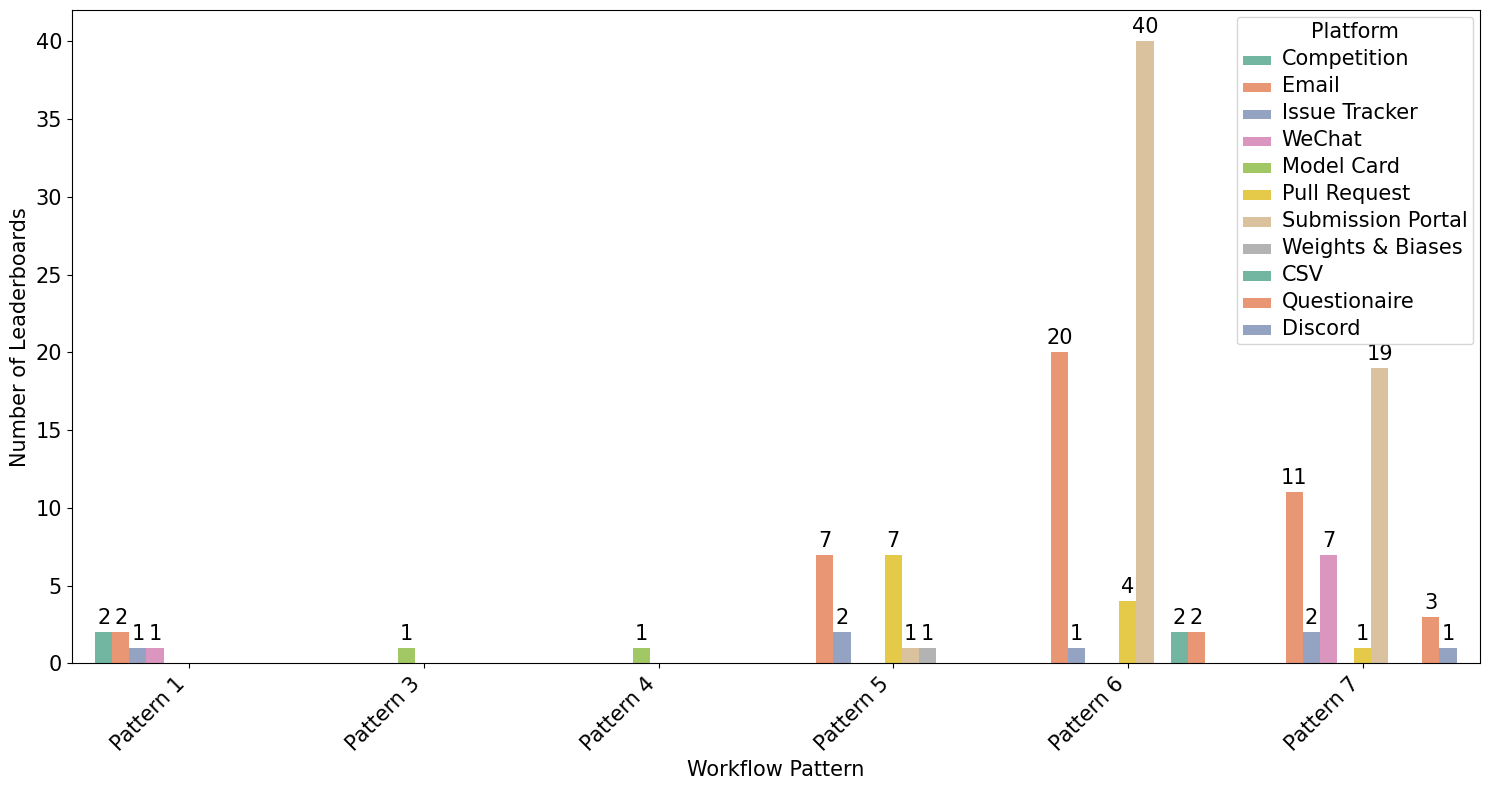

In [35]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['Platforms'] != "['Papers With Code']"]
print(f'There are {len(df)} non-pwc leaderboard systems.')

df['Evaluation workflows (non-pwc)'] = df['Evaluation workflows (non-pwc)'].apply(ast.literal_eval)
df['Submission avenues (non-pwc)'] = df['Submission avenues (non-pwc)'].apply(ast.literal_eval)
df_submission = df[df['Submission avenues (non-pwc)'].map(len) > 0]
print(f"{round(len(df_submission)/len(df)*100,2)}% ({len(df_submission)} out of {len(df)}) leaderboards provide at least one submission & collection guideline for new evaluation records.")

df_split = df_submission.explode('Evaluation workflows (non-pwc)').explode('Submission avenues (non-pwc)')
df_split = df_split.groupby(['Evaluation workflows (non-pwc)', 'Submission avenues (non-pwc)']).size().reset_index(name='Frequency')
df_split.sort_values(by=['Evaluation workflows (non-pwc)', 'Submission avenues (non-pwc)'], inplace=True)

df_split['Evaluation workflows (non-pwc)'] = df_split['Evaluation workflows (non-pwc)'].apply(lambda x: f'Pattern {x}' if x != 'Unknown' else x)
df_avenue = df_split.groupby('Submission avenues (non-pwc)').sum().reset_index()
df_avenue.sort_values(by='Frequency', ascending=False, inplace=True)
df_avenue['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Submission & Collection Avenues',
    'Mean': np.mean(df_avenue['Frequency']),
    'Median': np.median(df_avenue['Frequency']),
    'IQR': df_avenue['Frequency'].quantile(0.75) - df_avenue['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_avenue, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_paper / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=df_avenue['Submission avenues (non-pwc)'], 
    y=df_avenue['Frequency'],
    text_auto=True,
    labels={'x': 'Submission avenues (non-pwc)', 'y': 'Leaderboard Number'},
    title='Number of Leaderboard Systems across Submission & Collection Avenues (non-pwc)'
)
fig.show()

df_split = df_split[df_split['Evaluation workflows (non-pwc)'] != 'Unknown']
for name, group in df_split.groupby('Evaluation workflows (non-pwc)'):
    group = group.sort_values(by='Frequency', ascending=False)
    print(f"{group['Submission avenues (non-pwc)'].iloc[0]} is the most prevalent avenue in evaluation workflow {name}, accounting for {round(group['Frequency'].iloc[0]/group['Frequency'].sum()*100,2)}% ({group['Frequency'].iloc[0]} out of {group['Frequency'].sum()}) leaderboard systems.")

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed
ax = sns.barplot(
    x='Evaluation workflows (non-pwc)', 
    y='Frequency', 
    hue='Submission avenues (non-pwc)',  # This separates the bars within each group by platform
    data=df_split, 
    palette='Set2',  # Choose a palette that makes the bars distinct
    dodge=True  # Adjust this to control the gap between bars of different platforms within the same group
)

# Setting the title and labels with enlarged fonts
ax.set_xlabel('Workflow Pattern', fontsize=font_size)  # Enlarge x-axis label
ax.set_ylabel('Number of Leaderboards', fontsize=font_size)  # Enlarge y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Enlarge axis ticks font size
ax.tick_params(axis='both', which='major', labelsize=font_size)

# Adding annotations on top of each bar
for p in ax.patches:
    if p.get_height():
        ax.annotate(format(p.get_height(), '.0f'),  # Format the number presentationed
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha = 'center', va = 'center', 
                xytext = (0, 10),  # Distance from the top of the bar
                textcoords = 'offset points', fontsize=font_size)

# Adjust the legend
leg = ax.legend(title='Submisstion Avenue')
leg.set_title('Platform', prop={'size':font_size})  # Set the title font size
for text in leg.get_texts():  # Set the font size for each legend text
    text.set_fontsize(font_size)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
# Save the plot to a PDF file
plt.savefig(path_paper / 'workflow-pattern-distribution.pdf', bbox_inches='tight')
plt.show()

In [41]:
# df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
# df = df[~df['Platforms'].str.contains('GitHub|Papers With Code')]
# df['Feedback venues (hf+ip)'] = df['Feedback venues (hf+ip)'].apply(ast.literal_eval)

# df_hf = df[df['Platforms'].str.contains('Hugging Face')]
# print(f'There are {len(df_hf)} leaderboards hosted on Hugging Face.')
# df_hf = df_hf.explode('Feedback venues (hf+ip)')['Feedback venues (hf+ip)'].value_counts().reset_index(name='Frequency')
# print(df_hf)

# df_ip = df[df['Platforms'].str.contains('independent platform')]
# print(f'There are {len(df_ip)} leaderboards hosted on independent platforms.')
# df_ip = df_ip.explode('Feedback venues (hf+ip)')['Feedback venues (hf+ip)'].value_counts().reset_index(name='Frequency')
# print(df_ip)

There are 21 leaderboards hosted on Hugging Face.
  Feedback venues (hf+iw)  Frequency
0                 Contact         21
1                  GitHub         12
There are 58 leaderboards hosted on independent platforms.
  Feedback venues (hf+iw)  Frequency
0                 Contact         57
1                  GitHub         27


In [36]:
df = pd.read_csv(path_paper / 'leaderboard_processed.csv')
df = df[df['Platforms'] != "['Papers With Code']"]
df_structure = df[df['#Organization strategy'] > 0]
print(f'There are {len(df_structure)} non-pwc leaderboards that have adopted organization strategies, accounting for {round(len(df_structure)/len(df)*100,2)}% of the total.')
df_structure['Organization strategies'] = df_structure['Organization strategies'].apply(ast.literal_eval)
df_split = df_structure.explode('Organization strategies')

df_number = pd.DataFrame()
for index, (name, group) in enumerate(df_split.groupby('Organization strategies')):
    entry = {
        'Index': index, # Temporarily store the original index
        'Organization strategy': name,
        'Overarching category': leaderboard_organization_tactics_mapping_inverse[name],
        'Prevalence (%)': len(group)/len(df_structure)*100,
    }
    df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

df_number = df_number.sort_values(by=['Organization strategy']).reset_index(drop=True)
df_number['Index'] = df_number.index + 1
df_number['Index'] = df_number['Index'].apply(lambda x: f'$C_{{0{x}}}$' if x < 10 else f'$C_{{{x}}}$')
print(df_number.to_latex(float_format="%.2f", index=False))

df_number = df_number.groupby('Overarching category')['Prevalence (%)'].sum().reset_index()
df_number = df_number.sort_values(by=['Prevalence (%)'], ascending=False)
fig = px.bar(
    title='Distribution of Leaderboard Systems across Overarching Organization Strategies',
    x=df_number['Overarching category'],
    y=df_number['Prevalence (%)'],
    text_auto=True,
    labels={'x': 'Overarching category', 'y': 'Leaderboard Number'},
)
fig.show()

There are 102 non-pwc leaderboards that have adopted organization strategies, accounting for 45.95% of the total.


C:\Users\zhimi\AppData\Local\Temp\ipykernel_20904\1783831393.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



\begin{tabular}{lllr}
\toprule
Index & Organization strategy & Overarching category & Prevalence (%) \\
\midrule
$C_{01}$ & #Prompt Example & Prompt Engineering & 5.88 \\
$C_{02}$ & Aggregated Result & Leaderboard Aggregation & 39.22 \\
$C_{03}$ & Benchmark Dataset & Model Capability & 17.65 \\
$C_{04}$ & Dataset Slice & Evaluation Configuration & 13.73 \\
$C_{05}$ & Evaluator & Evaluation Configuration & 9.80 \\
$C_{06}$ & Leaderboard Launch Date & Leaderboard Release & 1.96 \\
$C_{07}$ & Leaderboard Version & Leaderboard Release & 4.90 \\
$C_{08}$ & Metric & Evaluation Configuration & 9.80 \\
$C_{09}$ & Model Accessibility & Model Information & 4.90 \\
$C_{10}$ & Model Size & Model Information & 5.88 \\
$C_{11}$ & Model Type & Model Information & 1.96 \\
$C_{12}$ & Output Length & Prompt Engineering & 0.98 \\
$C_{13}$ & Prompt Design & Prompt Engineering & 1.96 \\
$C_{14}$ & Prompt Length & Prompt Engineering & 1.96 \\
$C_{15}$ & Relation Extractor & Prompt Engineering & 0.98 \\
$C_{

In [37]:
df = pd.read_csv(path_paper / 'leaderboard_statistics.csv')
df.fillna('$\\times$', inplace=True)
df['Mean'] = df['Mean'].map('{:.2f}'.format)
df['Median'] = df['Median'].map('{:.1f}'.format)
df['IQR'] = df['IQR'].map('{:.0f}'.format)
df['Gini Coefficient'] = df['Gini Coefficient'].map(lambda x: '{:.3f}'.format(x) if isinstance(x,float) else x)
print(df.to_latex(index=False))


\begin{tabular}{lllll}
\toprule
Distribution & Mean & Median & IQR & Gini Coefficient \\
\midrule
Evaluated Models across Leaderboard Systems & 68.67 & 16.0 & 24 & $\times$ \\
Evaluation Metrics across Leaderboard Systems & 3.21 & 2.0 & 3 & $\times$ \\
Evaluation Records across Leaderboard Systems & 184.87 & 23.0 & 48 & 0.873 \\
Leaderboard Systems across Downloadable Formats & 8.33 & 2.0 & 2 & 0.816 \\
Leaderboard Systems across Evaluated Models & 1.53 & 1.0 & 1 & 0.244 \\
Leaderboard Systems across Evaluation Metrics & 2.29 & 1.0 & 1 & 0.501 \\
Leaderboard Systems across Evaluation Workflows & 32.29 & 15.0 & 44 & 0.656 \\
Leaderboard Systems across Organization Strategies & 18.57 & 5.0 & 8 & 0.782 \\
Leaderboard Systems across Platforms & 113.00 & 94.0 & 50 & 0.270 \\
Leaderboard Systems across Presentation Formats & 53.92 & 5.0 & 21 & 0.838 \\
Leaderboard Systems across Release Organizations & 3.43 & 1.0 & 1 & 0.622 \\
Leaderboard Systems across Submission & Collection Avenues & 12.

C:\Users\zhimi\AppData\Local\Temp\ipykernel_20904\1268229585.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '$\times$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

